In [1]:
import os
import time
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

os.environ["RUNFILES_DIR"] = "/Users/rafa/opt/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/plaidml"
# plaidml might exist in different location. Look for "/usr/local/share/plaidml" and replace in above path

os.environ["PLAIDML_NATIVE_PATH"] = "/Users/rafa/opt/anaconda3/envs/dhdsblend/lib/libplaidml.dylib"
# libplaidml.dylib might exist in different location. Look for "/usr/local/lib/libplaidml.dylib" and replace in above path

In [59]:
import IPython.display as ipd
import numpy as np
import pandas as pd
import seaborn as sns

import utils

import tensorflow as tf

# Don't use tensorflow.keras anywhere, instead use keras
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from keras.utils import to_categorical

from matplotlib import pyplot

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback, EarlyStopping

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [3]:
# Custom options for visualization
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")

In [4]:
# Loading Data

tracks = utils.load('data/fma_metadata/tracks.csv')
genres = utils.load('data/fma_metadata/genres.csv')
features_df = utils.load('data/fma_metadata/features.csv')
echonest = utils.load('data/fma_metadata/echonest.csv')

In [5]:
# Splitting Data between rows with genre_top set and unset

tracks_genres_info = tracks['track'][['genre_top', 'genres', 'genres_all']] 
tracks_genres_info['track_id'] = tracks_genres_info.index

null_top_genre_mask_mask = tracks_genres_info.genre_top.isnull()

null_top_genre_tracks_df = tracks_genres_info.loc[null_top_genre_mask_mask,:]
not_null_top_genre_tracks_df = tracks_genres_info.loc[~null_top_genre_mask_mask,:]

In [6]:
def transform_genres_list_to_str(genres_list):
    return "|".join([str(x) for x in genres_list])

null_top_genre_tracks_df['genres_str'] = null_top_genre_tracks_df.genres.apply(transform_genres_list_to_str)
null_top_genre_tracks_df['genres_all_str'] = null_top_genre_tracks_df.genres_all.apply(transform_genres_list_to_str)

_df = null_top_genre_tracks_df.set_index('track_id').genres_str.str.split('|', expand=True).stack()

_df

/Users/rafa/opt/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/rafa/opt/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


track_id   
20        0     76
          1    103
26        0     76
          1    103
30        0     76
              ... 
155278    1    107
155288    0       
155320    0     10
          1     12
          2    169
Length: 169266, dtype: object

In [9]:
target_genres = dict(zip(list(genres[(genres.parent == 0)].index), list(genres[(genres.parent == 0)].title)))

null_top_genre_tracks_df['derived_genre_top'] = null_top_genre_tracks_df.genres.apply(choosing_top_genre, args=(genres,target_genres))

(~null_top_genre_tracks_df.isnull()).sum()

/Users/rafa/opt/anaconda3/envs/dhdsblend/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


genre_top                0
genres               56976
genres_all           56976
track_id             56976
genres_str           56976
genres_all_str       56976
derived_genre_top    54745
dtype: int64

In [10]:
# Adding derived to a new DF

tracks_info_with_derived_top_genre_df = tracks_genres_info.copy()
tracks_info_with_derived_top_genre_df["_genre_top"] = ''

_df = null_top_genre_tracks_df[~null_top_genre_tracks_df.derived_genre_top.isnull()]

for index, row in tracks_genres_info.iterrows():
    if isinstance(row.genre_top, str) or (~np.isnan(row.genre_top)):
        tracks_info_with_derived_top_genre_df.at[index, '_genre_top'] = row.genre_top
    elif index in _df.index:
        tracks_info_with_derived_top_genre_df.at[index, '_genre_top'] = _df.at[index,'derived_genre_top']

In [11]:
tracks_info_with_derived_top_genre_df['duration'] = tracks.track['duration']
tracks_info_with_derived_top_genre_df['genre_top'] = tracks_info_with_derived_top_genre_df._genre_top

print((~tracks_info_with_derived_top_genre_df.genre_top.isnull()).sum())
print((~tracks_info_with_derived_top_genre_df._genre_top.isnull()).sum())

106574
106574


In [12]:
track_ids_genre_not_null_and_echonest = list(set(echonest.echonest.audio_features.index) & set(not_null_top_genre_tracks_df.index))
track_ids_derived_genre_and_echonest = list(set(echonest.echonest.audio_features.index) & set(null_top_genre_tracks_df.index))

print(len(track_ids_genre_not_null_and_echonest), len(track_ids_derived_genre_and_echonest))

features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence', 'tempo', 'duration']

original_genre_fetures_df = pd.concat([echonest.echonest.audio_features[echonest.index.isin(track_ids_genre_not_null_and_echonest)], tracks[tracks.index.isin(track_ids_genre_not_null_and_echonest)].track[['genre_top', 'duration']]], 1)
original_genre_fetures_df.head()

9355 3774


,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top,duration
track_id,,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop,168
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop,237
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop,206
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,Pop,161
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop,207


In [13]:
derived_genre_fetures_df = pd.concat([echonest.echonest.audio_features[echonest.index.isin(track_ids_derived_genre_and_echonest)], tracks_info_with_derived_top_genre_df[tracks_info_with_derived_top_genre_df.index.isin(track_ids_derived_genre_and_echonest)][['genre_top', 'duration']]], 1)
derived_genre_fetures_df.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top,duration
track_id,,,,,,,,,,
236,0.230013,0.848918,0.444921,0.820067,0.162606,0.101744,120.095,0.846313,Electronic,309
461,0.984355,0.571168,0.319628,0.030623,0.567914,0.050290,107.232,0.788501,Blues,328
462,0.983755,0.648854,0.273137,0.258233,0.665152,0.033117,115.764,0.517182,Blues,323
463,0.987198,0.694961,0.309419,0.340356,0.102491,0.039797,115.397,0.554299,Blues,224
464,0.978804,0.618105,0.381706,0.609562,0.100077,0.067830,114.829,0.622699,Blues,397


In [14]:
# Add extra technical features to dataset


_features = ["chroma_cens", "chroma_cqt", "chroma_stft", "mfcc", "rmse", "spectral_bandwidth", "spectral_contrast", "spectral_rolloff", "tonnetz", "zcr"]
_fields = ["kurtosis", "mean", "std", "median", "max", "min"]

# Collecting only the needed rows for both datasets
audio_features_df  = features_df[features_df.index.isin(list(original_genre_fetures_df.index) + list(derived_genre_fetures_df.index))][_features]

# Flatten features

tracks_with_extra_audio_features_df = pd.DataFrame(index=audio_features_df.index)

## Initializing all needed columns with NaN
for index, row in audio_features_df.head(1).iterrows():
    for feature in _features:
        for field in _fields:
            i = 0
            for k in row[feature][field]: # channel (if it is channel ?)                
                i += 1
                tracks_with_extra_audio_features_df[f'{feature}_{field[0:3]}_{i}'] = np.nan

# Populating each row with audio analysis feature values
start = time.time()
_count = 0
for index, row in audio_features_df.iterrows():
    _count += 1
    for feature in _features:
        for field in _fields:
            i = 0
            for k in row[feature][field]: # channel (if it is channel ?)                
                i += 1
                tracks_with_extra_audio_features_df.at[index, f'{feature}_{field[0:3]}_{i}'] = k                
    if _count % 1000 == 0:
        print(_count, f'{time.time() - start}')
stop = time.time()

print(f"Extending data took: {stop - start}s")

print(tracks_with_extra_audio_features_df.shape)

1000 30.575466871261597
2000 61.39288282394409
3000 91.8781361579895
4000 122.28312301635742
5000 152.67834901809692
6000 183.08112621307373
7000 213.54721689224243
8000 244.03383898735046
9000 274.41983699798584
10000 304.8415439128876
11000 335.5496530532837
12000 367.2384397983551
13000 400.09507608413696
Extending data took: 404.54425501823425s
(13129, 438)


In [16]:
extra_audio_genre_df = pd.concat([original_genre_fetures_df, tracks_with_extra_audio_features_df[tracks_with_extra_audio_features_df.index.isin(original_genre_fetures_df.index)]], 1)
extra_audio_derived_genre_df = pd.concat([derived_genre_fetures_df, tracks_with_extra_audio_features_df[tracks_with_extra_audio_features_df.index.isin(derived_genre_fetures_df.index)]], 1)

print(extra_audio_genre_df.shape)

(9355, 448)


In [47]:
original_genre_data_audio_features = basic_data_preparation(
    extra_audio_genre_df, 
    scaler_class=RobustScaler,
    features=extra_audio_genre_df.drop('genre_top', axis=1).columns
)

In [48]:
original_genre_data_audio_features['X_train'].shape

(7484, 447)

In [49]:
X_train, y_train = (np.array(original_genre_data_audio_features['X_train']), original_genre_data_audio_features['y_train'])

X_test, y_test = (np.array(original_genre_data_audio_features['X_test']), original_genre_data_audio_features['y_test'])

14

In [55]:
_genres_to_study = ['Rock', 'Hip-Hop', 'Folk', 'Blues', 'Classical', 'Instrumental', 'Jazz', 'Old-Time / Historic']

# Genre Filters
X_train = X_train[y_train.isin(_genres_to_study)]
y_train = y_train[y_train.isin(_genres_to_study)]

X_test = X_test[y_test.reset_index().genre_top.isin(_genres_to_study)]
y_test = y_test[y_test.isin(_genres_to_study)].reset_index().genre_top

y_train_le = to_categorical(y_train.cat.codes)
y_test_le = to_categorical(y_test.cat.codes)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5351, 447) (5351,)
(1338, 447) (1338,)


In [56]:
eval_metric = tf.keras.metrics.AUC(
    num_thresholds=200,
    curve="PR",
    summation_method="interpolation"
)

In [71]:
def create_model():
	# create model
    model = Sequential()
    model.add(Dense(32, input_dim=447, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(14, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy', 'categorical_crossentropy'])
    return model

keras_model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=1)

In [72]:
start = time.time()

km = keras_model.fit(X_train, y_train_le, epochs=100, verbose=0)

stop = time.time()

print(f"Extending data took: {stop - start}s")


Extending data took: 448.8790879249573s


1338/1338 [==============================] - 0s 267us/step
              precision    recall  f1-score   support

           0       0.50      0.38      0.43        13
           1       0.87      0.87      0.87        53
           6       0.71      0.65      0.68       175
           7       0.81      0.80      0.80       182
           8       0.55      0.35      0.43        17
          10       0.42      0.46      0.44        48
          11       0.99      0.93      0.96        71
          13       0.87      0.90      0.88       779

    accuracy                           0.82      1338
   macro avg       0.71      0.67      0.69      1338
weighted avg       0.82      0.82      0.82      1338



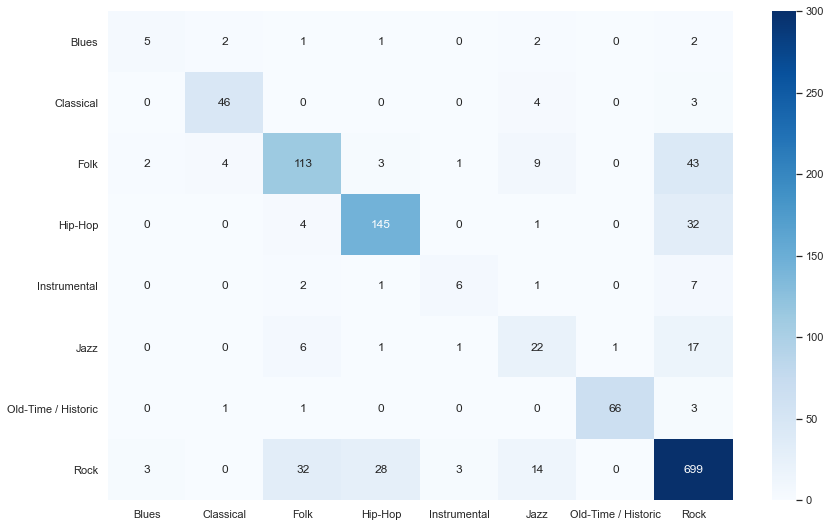

In [73]:
y_train_num = y_train.cat.codes.astype('int32')
y_test_num = y_test.cat.codes.astype('int32')

oredered_genres = list(y_train.unique())
oredered_genres.sort()

predictions = list(keras_model.predict(X_test))
print(classification_report(y_test_num, predictions))

cm = confusion_matrix(y_test_num, predictions)

custom_plot_confusion_matrix(cm, genre_list=oredered_genres)

In [8]:
def custom_plot_confusion_matrix(confusion_matrix, genre_list=['Blues', 'Hip-Hop','Jazz', 'Pop', 'Rock'], vmax=300):
    df_cm = pd.DataFrame(confusion_matrix, index = genre_list, columns = genre_list)
    pyplot.figure(figsize = (14,9))
    sns.heatmap(df_cm, annot=True, fmt='g', cmap="Blues", vmax=vmax)

def choosing_top_genre(genres_list, genres_df, target_genres): 
    for genre_id in genres_list:
        return target_genres[genres_df.loc[genre_id,'top_level']]            
    return np.NaN

def basic_data_preparation(df, scaler_class=StandardScaler, features=[], extra_data=None):
    
    X = df.drop('genre_top', axis=1)
    y = df['genre_top']

    scaler = scaler_class()
    X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7, stratify=y)

    X_train_sc_df = pd.DataFrame(X_train, columns = features)
    X_test_sc_df = pd.DataFrame(X_test, columns = features)
    
    if extra_data is not None:
        scaled_extra_data = scaler.transform(extra_data.drop('genre_top', axis=1))
        scaled_extra_data_df = pd.DataFrame(scaled_extra_data, columns = features)
        #print(scaled_extra_data_df.tail(10))
        scaled_extra_data_df = pd.concat([scaled_extra_data_df, extra_data.genre_top.reset_index().drop('track_id', axis=1)], axis=1)
        #print(scaled_extra_data_df.tail(10))
    return {
        "X_train": X_train_sc_df,
        "y_train": y_train,
        "X_test":  X_test_sc_df,
        "y_test":  y_test,
        "extra_data": scaled_extra_data_df if extra_data is not None else None
    }

In [60]:
def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value
